In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pylab import rcParams
from transformers import AutoTokenizer, DistilBertForSequenceClassification
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

sns.set()
%matplotlib inline



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install wordcloud

In [4]:
!pip install wandb

In [5]:
import wandb

In [6]:
!pip install nlpaug


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.6 MB/s eta 0:00:00


In [7]:
!pip install bertopic

  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/f8/26/ca0f1bb049b83c25cafa39f3fa5287c826a6ab36e665c906209e07f4deac/Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━

# **1. Exploring Data**

In [8]:

train_df  = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [9]:
train_df.shape 

(7613, 5)

In [10]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
train_df["text"].iloc[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [12]:
for i, text in enumerate(train_df['text'][:10]):
    print(f'text #{i}')
    print(text + '\n')

text #0
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

text #1
Forest fire near La Ronge Sask. Canada

text #2
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

text #3
13,000 people receive #wildfires evacuation orders in California 

text #4
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

text #5
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires

text #6
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas

text #7
I'm on top of the hill and I can see a fire in the woods...

text #8
There's an emergency evacuation happening now in the building across the street

text #9
I'm afraid that the tornado is coming to our area...



In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_len', ylabel='Count'>

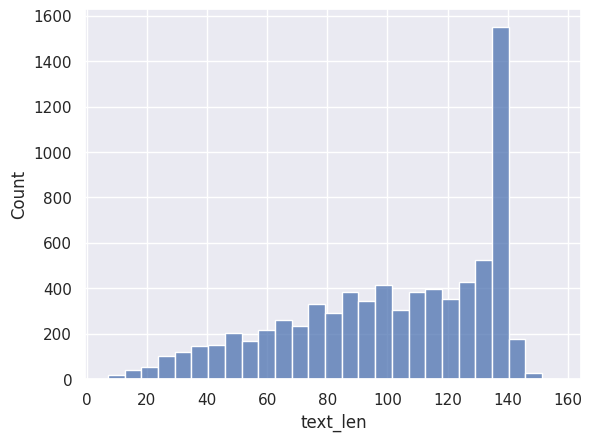

In [15]:
train_df['text_len'] = train_df['text'].apply(len)
sns.histplot(train_df['text_len'], kde=False)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

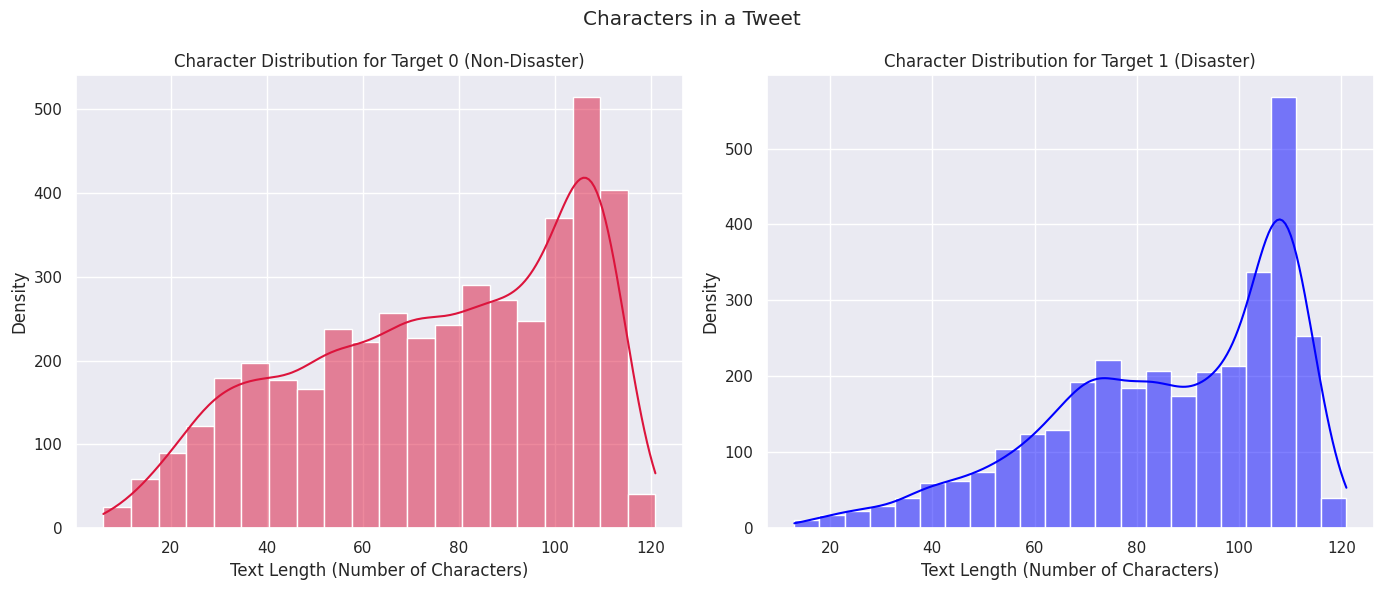

In [16]:
target_0_text = train_df[train_df['target'] == 0]['text']
target_1_text = train_df[train_df['target'] == 1]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

def create_char_distribution_histogram(text, target_name, ax):
    text = text.str.replace(r'\W', ' ', regex=True)  
    text = text.str.lower()  
    text = text.str.replace(' ', '')  
    text_length = text.str.len()
    
    sns.histplot(text_length, kde=True, color='blue' if target_name == '1 (Disaster)' else 'crimson', ax=ax)
    
    ax.set_xlabel('Text Length (Number of Characters)')
    ax.set_ylabel('Density')
    ax.set_title(f'Character Distribution for Target {target_name}')

create_char_distribution_histogram(target_0_text, '0 (Non-Disaster)', ax1)
create_char_distribution_histogram(target_1_text, '1 (Disaster)', ax2)

plt.suptitle('Characters in a Tweet')
plt.tight_layout()
plt.show()

In [17]:
train_df, valid_df = train_test_split(train_df,stratify=train_df.target ,test_size =0.2 ,random_state=RANDOM_SEED )

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


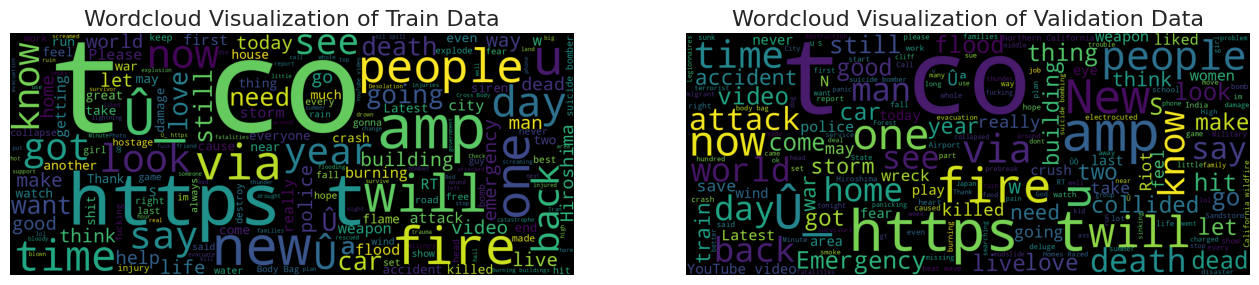

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_and_display_wordcloud(data, title, ax):
    wordcloud = WordCloud(width=1400, height=600, background_color='black').generate(''.join(text for text in data['text']))
    
    ax.imshow(wordcloud)
    ax.set_title(f'Wordcloud Visualization of {title}', fontsize=16)
    ax.axis('off')
    
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

generate_and_display_wordcloud(train_df, 'Train Data', axs[0])
generate_and_display_wordcloud(valid_df, 'Validation Data', axs[1])

plt.show()

Topic Modeling


In [19]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
import re
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
import nltk
from bertopic import BERTopic
import random
import nlpaug.augmenter.word as naw

# Get the set of English stop words
stop = set(stopwords.words('english'))

def word_swap(text, p=0.1):
    # Introduce noise (word swapping) to the text
    words = word_tokenize(text)
    for i in range(len(words) - 1):
        if random.random() < p:
            words[i], words[i + 1] = words[i + 1], words[i]
    return ' '.join(words)

def tok(context):
    context = str(context).lower()
    context = ' '.join(re.findall("[A-Za-z]{3,}", str(re.sub(r'http\S+', '', str(context)))))
    words = word_tokenize(context)  # Use word_tokenize from nltk.tokenize
    words = [element for element in words if element.isalpha()]  # Keep only alphabetic words
    list_words = [w for w in words if w not in stop]

    # Introduce noise (word swapping) to the list of words
    noisy_words = [word_swap(word) for word in list_words]

    return ' '.join(noisy_words)



train_df['clean'] = train_df['text'].apply(tok)
valid_df['clean'] = valid_df['text'].apply(tok)

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
docs = train_df['clean'].tolist()
topics, probs = topic_model.fit_transform(docs)

freq = topic_model.get_topic_info()
freq.head(5)


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2023-11-22 07:31:52,941 - BERTopic - Transformed documents to Embeddings
2023-11-22 07:32:23,116 - BERTopic - Reduced dimensionality
2023-11-22 07:32:30,184 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1701,-1_fire_like_amp_people,"[fire, like, amp, people, day, battle, one, to...",[rly tragedy live recount horror saw coaches t...
1,0,114,0_mass_murder_murderer_theater,"[mass, murder, murderer, theater, antioch, mas...",[abc parents colorado theater shooting victim ...
2,1,86,1_earthquake_utc_seismic_volcano,"[earthquake, utc, seismic, volcano, hawaii, us...",[usgs reports earthquake volcano hawaii utc qu...
3,2,86,2_screams_screamed_screaming_arianagrande,"[screams, screamed, screaming, arianagrande, l...","[justinbieber arianagrande screaming, screams,..."
4,3,83,3_bloody_heart_pandemonium_mary,"[bloody, heart, pandemonium, mary, lover, laur...",[envw nickcocofree juliedicaro jdabe worst per...


In [21]:
freq.head(1)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1701,-1_fire_like_amp_people,"[fire, like, amp, people, day, battle, one, to...",[rly tragedy live recount horror saw coaches t...


Data Cleaning


In [22]:
train_df.head()

,id,keyword,location,text,target,text_len,clean
6234,8902,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky...,1,116,sassy city girl country hunk stranded smoky mo...
326,472,armageddon,Worldwide,God's Kingdom (Heavenly Gov't) will rule over ...,0,135,god kingdom heavenly gov rule people earth arm...
997,1448,body%20bagging,Cloud 9,Mopheme and Bigstar Johnson are a problem in t...,0,86,mopheme bigstar johnson problem game body bagg...
7269,10407,whirlwind,Sheff/Bangor/Salamanca/Madrid,@VixMeldrew sounds like a whirlwind life!,0,41,vixmeldrew sounds like whirlwind life
2189,3137,debris,Nigeria,Malaysia confirms plane debris washed up on Re...,1,102,malaysia confirms plane debris washed reunion ...


In [23]:
train_df.drop(columns=['text'], inplace=True)

In [24]:
# Rename the 'clean' column to 'text' in the train_df DataFrame
train_df.rename(columns={'clean': 'text'}, inplace=True)

# Display the updated DataFrame
print(train_df.head())


         id         keyword                       location  target  text_len  \
6234   8902       snowstorm                     South, USA       1       116   
326     472      armageddon                      Worldwide       0       135   
997    1448  body%20bagging                        Cloud 9       0        86   
7269  10407       whirlwind  Sheff/Bangor/Salamanca/Madrid       0        41   
2189   3137          debris                       Nigeria        1       102   

                                                   text  
6234  sassy city girl country hunk stranded smoky mo...  
326   god kingdom heavenly gov rule people earth arm...  
997   mopheme bigstar johnson problem game body bagg...  
7269              vixmeldrew sounds like whirlwind life  
2189  malaysia confirms plane debris washed reunion ...  


In [25]:
train_df['Topic'] = topics
valid_df['Topic'] = topic_model.transform(valid_df['clean'].tolist())[0]  # Transform the validation set as well


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2023-11-22 07:32:49,554 - BERTopic - Reduced dimensionality
2023-11-22 07:32:51,705 - BERTopic - Calculated probabilities with HDBSCAN
2023-11-22 07:32:51,706 - BERTopic - Predicted clusters


In [26]:
def cleaned_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","", regex=True) # replaces hashtags
    text = text.str.replace(r"http\S+","URL", regex=True)  # remove URL addresses
    text = text.str.replace(r"@","", regex=True)
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ", regex=True)
    text = text.str.replace("\s{2,}", " ", regex=True)
    return text

In [27]:
train_df["text"]=cleaned_text(train_df["text"])

In [28]:
train_df.head()

,id,keyword,location,target,text_len,text,Topic
6234,8902,snowstorm,"South, USA",1,116,sassy city girl country hunk stranded smoky mo...,-1
326,472,armageddon,Worldwide,0,135,god kingdom heavenly gov rule people earth arm...,124
997,1448,body%20bagging,Cloud 9,0,86,mopheme bigstar johnson problem game body bagg...,41
7269,10407,whirlwind,Sheff/Bangor/Salamanca/Madrid,0,41,vixmeldrew sounds like whirlwind life,104
2189,3137,debris,Nigeria,1,102,malaysia confirms plane debris washed reunion ...,18


In [29]:
train_df.target.value_counts()

target
0    3473
1    2617
Name: count, dtype: int64

In [30]:
import transformers

from transformers import AutoTokenizer, AutoModel

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_model  = AutoModel.from_pretrained(MODEL, return_dict = False)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [32]:
#topic as feature 
class CaseDataset(Dataset):
    def __init__(self, reviews, targets, topics, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.topics = topics  
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        topic = self.topics[item]  # Extract the topic from the dataframe
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'topics': torch.tensor(topic, dtype=torch.float32)  # Assuming 'topics' is numerical
        }


In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CaseDataset(
        reviews=df.text.to_numpy(),
        targets=df.target.to_numpy(),
        topics=df.Topic.to_numpy(),  # Add topics
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)


In [34]:
# wandb.init(project='ai-project29', config={
#     'batch_size': 32,
#     'max_len':128,
#     'learning_rate': 3e-6,
#     'epochs': 10,
# })

In [35]:
BATCH_SIZE = 32
MAX_LEN = 128


train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(valid_df, tokenizer, MAX_LEN, BATCH_SIZE)

     

In [36]:
data = next(iter(train_data_loader))
data.keys()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'topics'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [38]:
sample_txt = train_df.text[0]
sample_txt
     

'deeds reason earthquake may allah forgive'

In [39]:
encoding = tokenizer.encode_plus(
  sample_txt,
  
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  max_length=128,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [40]:
last_hidden_state, pooled_output = roberta_model(
input_ids=encoding['input_ids'],
attention_mask=encoding['attention_mask'])
     

In [41]:
roberta_model.config.hidden_size


768

In [42]:
encoding["input_ids"].shape

torch.Size([1, 128])

In [43]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [44]:
#feature
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(SentimentClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(MODEL, return_dict=False)
        self.drop = nn.Dropout(p=0.1)
        self.out1 = nn.Linear(self.roberta.config.hidden_size + 1, 768)  # Adjust the size here
        self.relu1 = nn.ReLU()
        self.out = nn.Linear(768, 2)
        
    def forward(self, input_ids, attention_mask, topics):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        
        # If 'topics' has only one dimension, add a new dimension
        if topics.dim() == 1:
            topics = topics.unsqueeze(1)
        
        # Concatenate the 'topics' tensor along the last dimension
        output = torch.cat([output, topics], dim=-1)
        output = self.out1(output)
        output = self.relu1(output)
        return self.out(output)





In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
model = SentimentClassifier()
model = model.to(device)
     

In [47]:
print(model)


SentimentClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
     

torch.Size([32, 128])
torch.Size([32, 128])


In [49]:
import torch.nn.functional as F

In [50]:
F.softmax(model(input_ids, attention_mask, data['topics'].to(device)), dim=1)


tensor([[0.4803, 0.5197],
        [0.5011, 0.4989],
        [0.4804, 0.5196],
        [0.4809, 0.5191],
        [0.4585, 0.5415],
        [0.4705, 0.5295],
        [0.4695, 0.5305],
        [0.5029, 0.4971],
        [0.4974, 0.5026],
        [0.4503, 0.5497],
        [0.4914, 0.5086],
        [0.4861, 0.5139],
        [0.4734, 0.5266],
        [0.5001, 0.4999],
        [0.5144, 0.4856],
        [0.4852, 0.5148],
        [0.4978, 0.5022],
        [0.4748, 0.5252],
        [0.4710, 0.5290],
        [0.4764, 0.5236],
        [0.4762, 0.5238],
        [0.4736, 0.5264],
        [0.4859, 0.5141],
        [0.4610, 0.5390],
        [0.5181, 0.4819],
        [0.5142, 0.4858],
        [0.4664, 0.5336],
        [0.4747, 0.5253],
        [0.4558, 0.5442],
        [0.4802, 0.5198],
        [0.4873, 0.5127],
        [0.5113, 0.4887]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [51]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=3e-6)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)
     

In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.to(device)
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            topics = data['topics'].to(device)  
            targets = data['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, topics=topics)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    accuracy = correct_predictions.double() / n_examples
    average_loss = np.mean(losses)

    return accuracy, average_loss


In [54]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [55]:
# Training loop
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    model.train()
    losses = []
    correct_predictions = 0

    for data in train_data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        topics = data['topics'].to(device)  
        targets = data['targets'].to(device)

        # Move the model to the device inside the loop
        model = model.to(device)

        # Call the model's forward method with the 'topics' tensor
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, topics=topics)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_acc = correct_predictions.double() / len(train_df)
    train_loss = np.mean(losses)

    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Validation loop
    model.eval()
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(valid_df))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Log metrics to WandB
    # wandb.log({
    #     'epoch': epoch + 1,
    #     'train_loss': train_loss,
    #     'train_accuracy': train_acc,
    #     'val_loss': val_loss,
    #     'val_accuracy': val_acc,
    # })

    history['epoch'].append(epoch + 1)
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss.item())
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss.item())

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc



Epoch 1/10
----------
Train loss 0.550392259633978 accuracy 0.7517241379310345
Val   loss 0.4353481487681468 accuracy 0.81483913328956

Epoch 2/10
----------
Train loss 0.43171190349531424 accuracy 0.8192118226600985
Val   loss 0.4103428727636735 accuracy 0.8214051214707813

Epoch 3/10
----------
Train loss 0.39769606931983487 accuracy 0.8395730706075534
Val   loss 0.3951112302020192 accuracy 0.8332239001969796

Epoch 4/10
----------
Train loss 0.37356509549143424 accuracy 0.8509031198686371
Val   loss 0.39577460785706836 accuracy 0.8319107025607353

Epoch 5/10
----------
Train loss 0.3560465286773537 accuracy 0.8620689655172414
Val   loss 0.40124522739400464 accuracy 0.829940906106369

Epoch 6/10
----------
Train loss 0.3427159283407696 accuracy 0.8642036124794745
Val   loss 0.39607019753505784 accuracy 0.8384766907419566

Epoch 7/10
----------
Train loss 0.33380849589228007 accuracy 0.8711001642036125
Val   loss 0.397506680029134 accuracy 0.8384766907419566

Epoch 8/10
----------
Tra

In [56]:
# wandb.finish()

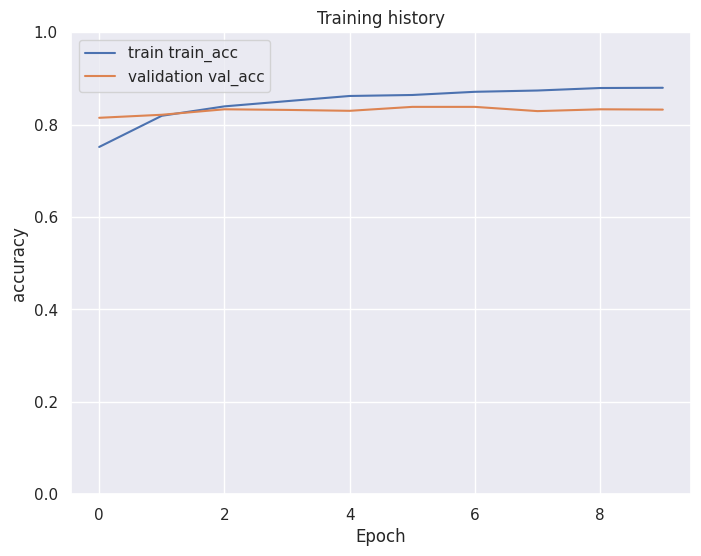

In [57]:
rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_acc'], label='train train_acc')
plt.plot(history['val_acc'], label='validation val_acc')

plt.title('Training history')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

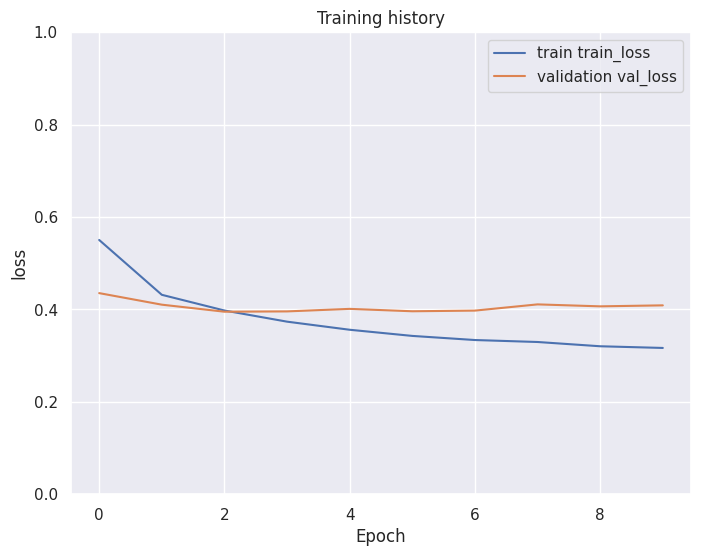

In [58]:


rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_loss'], label='train train_loss')
plt.plot(history['val_loss'], label='validation val_loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);